In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
%matplotlib inline

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Deep Learning/New york taxi fare prediction/taxifare.csv')

In [4]:
data.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


<Axes: xlabel='passenger_count', ylabel='fare_amount'>

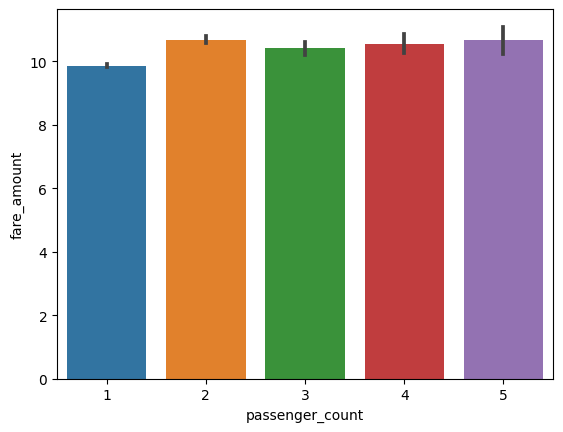

In [6]:
data['passenger_count'].unique()
sns.barplot(x=data['passenger_count'],y = data['fare_amount'])

In [7]:
#OBSERVATION: fare amount doesn't depend on no of passengers travelling from taxi.

<Axes: xlabel='fare_class', ylabel='fare_amount'>

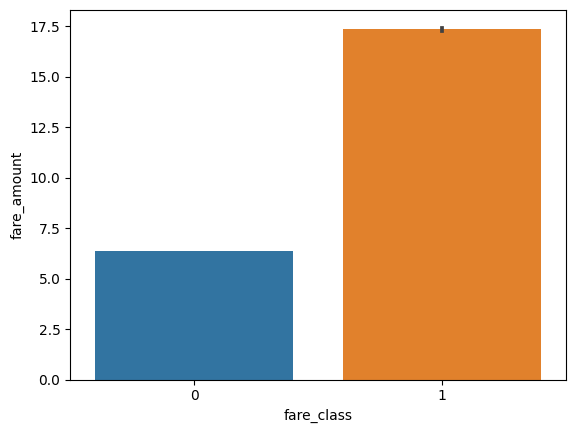

In [8]:
sns.barplot(x=data['fare_class'], y = data['fare_amount'])

In [9]:
#OBSERVATION:  Premium class taxies have higher fare amount

In [10]:
#subtract by 4 hours as UTC is 4 hours ahead of actual time
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime']) - datetime.timedelta(hours=4)

In [11]:
data['year'] = data['pickup_datetime'].dt.year
data['month'] = data['pickup_datetime'].dt.month
data['day'] = data['pickup_datetime'].dt.day
data['hours'] = data['pickup_datetime'].dt.hour
data['minutes'] = data['pickup_datetime'].dt.minute

In [12]:
data.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hours,minutes
0,2010-04-19 04:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2010,4,19,4,17
1,2010-04-17 11:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,2010,4,17,11,43
2,2010-04-17 07:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,2010,4,17,7,23
3,2010-04-11 17:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2010,4,11,17,25
4,2010-04-16 22:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,2010,4,16,22,19


In [13]:
#usually in early morning taxi fare is high. So lets create new feature mentioning daytime(morning/afternoon)
data['daytime'] = np.where(data['hours']<12,0,1)

In [14]:
data.drop(['pickup_datetime'],axis=1,inplace=True)

In [15]:
def harvesine(df):
  #calculate distance between two points on the earth
  lat1 = np.radians(data['pickup_latitude'])
  lat2 = np.radians(data['dropoff_latitude'])
  dlat =  np.radians(data['dropoff_latitude'] - data['pickup_latitude'])
  dlong =  np.radians(data['dropoff_longitude'] - data['pickup_longitude'])
  a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2) **2
  c = 2 * np.arctan2(np.sqrt(a),np.sqrt(1-a))
  r = 6371
  return c * r

In [16]:
data['Total_distance'] = harvesine(data)

In [17]:
data.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1,inplace=True)

In [18]:
data.head()

,fare_amount,fare_class,passenger_count,year,month,day,hours,minutes,daytime,Total_distance
0,6.5,0,1,2010,4,19,4,17,0,2.126312
1,6.9,0,1,2010,4,17,11,43,0,1.392307
2,10.1,1,2,2010,4,17,7,23,0,3.326763
3,8.9,0,1,2010,4,11,17,25,1,1.864129
4,19.7,1,1,2010,4,16,22,19,1,7.231321


In [19]:
X = data.iloc[:,2:]
y = data.iloc[:,:1]
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.2,random_state=1)

In [20]:
y

,fare_amount
0,6.5
1,6.9
2,10.1
3,8.9
4,19.7
...,...
119995,15.3
119996,15.3
119997,12.5
119998,4.9


In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
import xgboost
model = xgboost.XGBRegressor()
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [23]:
model.feature_importances_

array([0.01276354, 0.        , 0.        , 0.01877029, 0.03183578,
       0.01675745, 0.        , 0.919873  ], dtype=float32)

<Axes: >

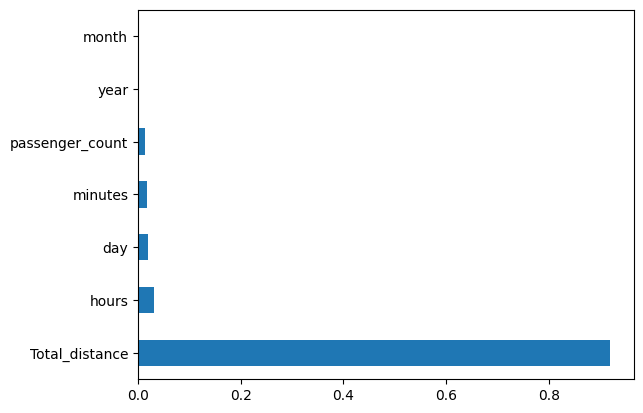

In [24]:
feature_importances = pd.Series(model.feature_importances_, index = data.iloc[:,2:].columns)
feature_importances.nlargest(7).plot(kind = 'barh')

In [25]:
y_pred = model.predict(X_test)

<ipython-input-26-941482159436>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_pred.reshape(-1,1))


<Axes: ylabel='Density'>

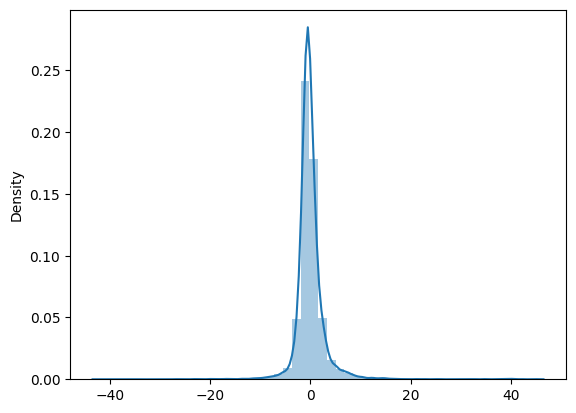

In [26]:
sns.distplot(y_test - y_pred.reshape(-1,1))

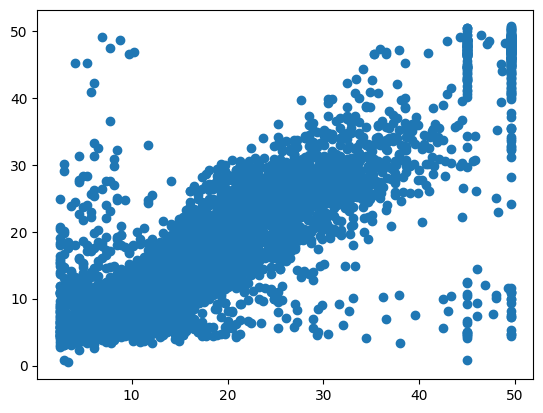

In [27]:
plt.scatter(y_test,y_pred)

In [28]:
print("R squared: ",r2_score(y_test,y_pred))
print("Mean squared error: ",mean_squared_error(y_test,y_pred))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("Mean absolute error: ",mean_absolute_error(y_test,y_pred))

R squared:  0.8117366715151101
Mean squared error:  10.545448862355249
Root mean squared error:  3.2473756885145346
Mean absolute error:  1.6907381769826513


## **Hyperparameter Tuning**





In [29]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(i) * 100 for i in range(1,6)]
learning_rate = ['0.05','0.1','0.02','0.03']
max_depth = [i * 5 for i in range(1,7)]

random_grid = {
    'n_estimators':n_estimators,
    'learning_rate': learning_rate,
    'max_depth':max_depth
}

In [30]:
xg_random = RandomizedSearchCV(estimator = model, param_distributions=random_grid,scoring='neg_mean_squared_error',n_iter = 2,cv=5,random_state=1)

In [31]:
xg_random.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=2,
                   param_distributions={'learning_rate': ['0.05', '0.1', '0.02',
                                                          '0.03'],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=1, scoring='neg_mean_squared_error')

In [32]:
xg_random.best_params_

{'n_estimators': 100, 'max_depth': 10, 'learning_rate': '0.03'}

In [33]:
y_pred = xg_random.predict(X_test)

In [35]:
print("R squared: ",r2_score(y_test,y_pred))
print("Mean squared error: ",mean_squared_error(y_test,y_pred))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("Mean absolute error: ",mean_absolute_error(y_test,y_pred))

R squared:  0.8074184936695763
Mean squared error:  10.787328807935236
Root mean squared error:  3.2844069187503604
Mean absolute error:  1.6794513722499211
